# Import data and aggregate

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import os
import re
import datetime as dt
from matplotlib import pyplot  as plt
import seaborn as sns
sns.set_style("darkgrid",{'font.sans-serif':['simhei','Arial'],'grid.linestyle': '--'})

In [2]:
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from visualization import *
from aggregation import *
from data_handling import *

In [11]:
# Aggregated data before August
past = pd.read_excel('summary.xlsx')

In [12]:
# import data from folder named '账单汇总', which is all the transaction data after 08-01
dir = "账单汇总"

filename_excel = []
frames = []
for root, dirs, files in os.walk(dir):
    for file in files:
        filename_excel.append(os.path.join(root, file))
        df = pd.read_csv(os.path.join(root, file), skiprows=[
                         0, 1, 2, 3], header=0, infer_datetime_format=True, date_parser = True,skipfooter=4, encoding="gbk")
        frames.append(df)
data = pd.concat(frames)

In [13]:
data = pd.concat([past,data])

In [16]:
data['备注'] = [i.encode('utf-8') for i in data.备注]
data['备注'] = [get_chinese(i)[0]  for i in data.备注]
types = ['公交赏金', '地铁赏金', '支付宝推荐奖励','商家权益红包']
data_bus = data[data['备注']==types[0]]
data_bus['发生时间']=pd.to_datetime(data_bus['发生时间'])
data_bus.reset_index(inplace = True, drop = True)

## 调用R

既然大家都用R做时间序列那R一定很不错……我们这里调用一下R吧

In [ ]:
import rpy2.robjects as robjects

In [ ]:
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

In [ ]:
pi = robjects.r['pi']

In [ ]:
piplus2 = robjects.r('pi') + 2

In [ ]:
p = pi+2

In [ ]:
l = robjects.r['letters']

In [ ]:
rcode = 'paste(%s, collapse="-")' %(l.r_repr())

In [ ]:
robjects.r(rcode).r_repr()

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R -w 500 -h 300 
library(ggplot2)
# data(iris)
p = ggplot(data,aes(x = Sepal.Length, y = Sepal.Width, color = Species)) + geom_point(size=4)
print(p

# Time Series Analysis

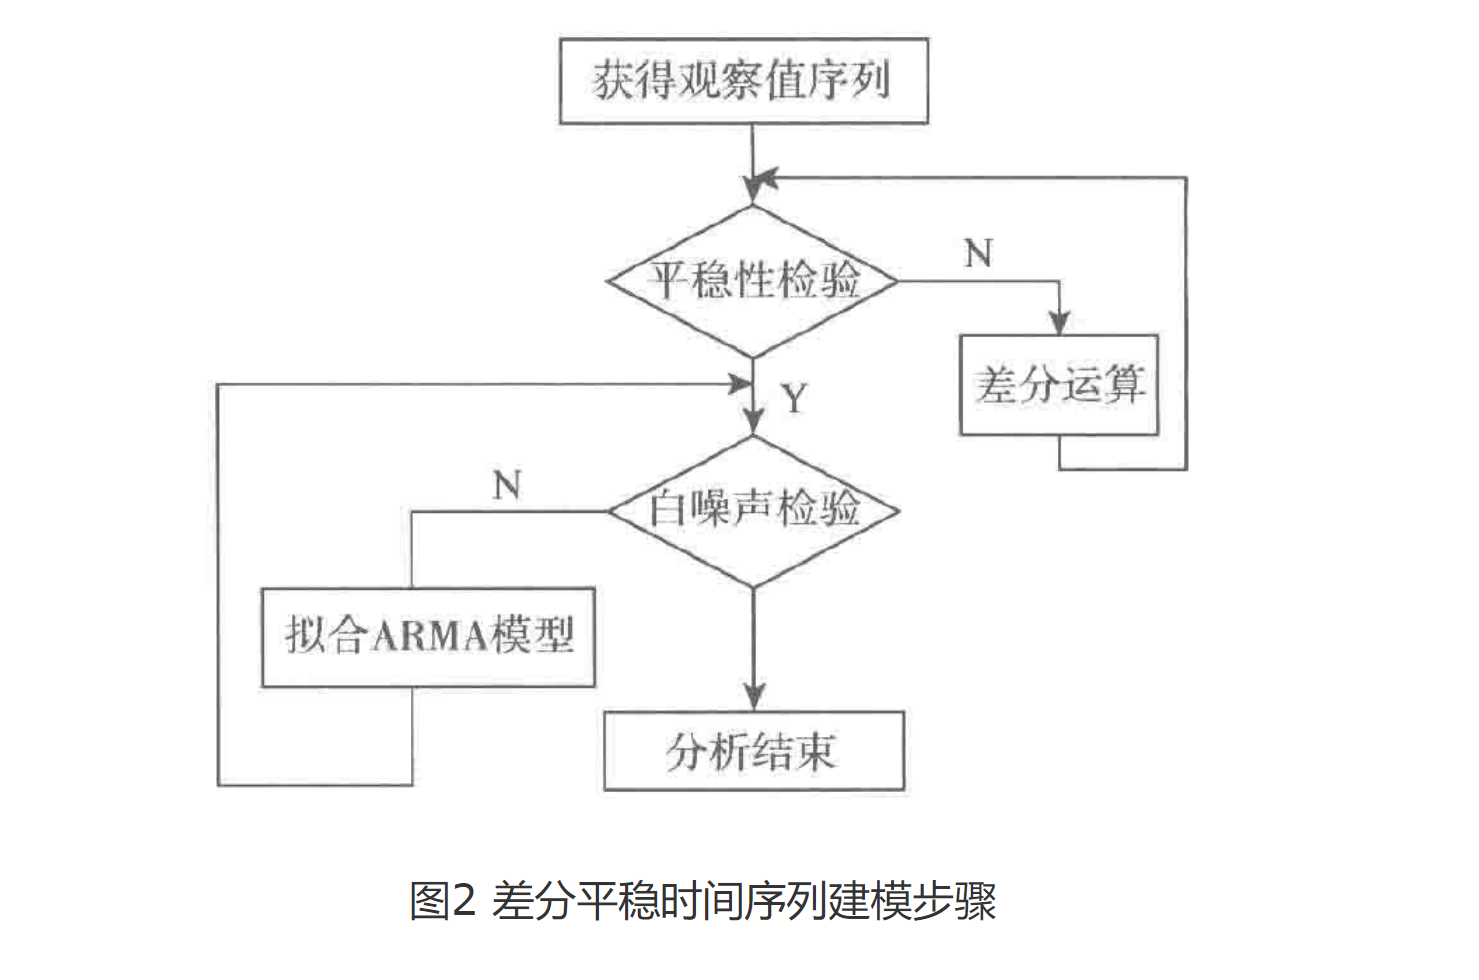


<img src="attachment:image.png" width="200">

## Time series preprocessing

### Obtaining Time Series

<ul>首先，我们需要获得观察值序列，在此例中我们把每个小时的收入聚合形成新dataframe，以日期时间为index，收入为值。把收入列赋值为新变量（是个pd.Series），这样后续调用的时候比较方便。（也可以每次调用的时候都单独调用这一列，但就有点麻烦咯）

In [19]:
df = data_bus[['发生时间', '收入金额（+元）']]
df['发生时间'] = [dt.datetime.strptime(x.strftime(
    '%Y-%m-%d:%H'), '%Y-%m-%d:%H') for x in df['发生时间']]  # 转换时间格式，方便后面聚合
df = df.pivot_table(index='发生时间', aggfunc='sum')  # 聚合

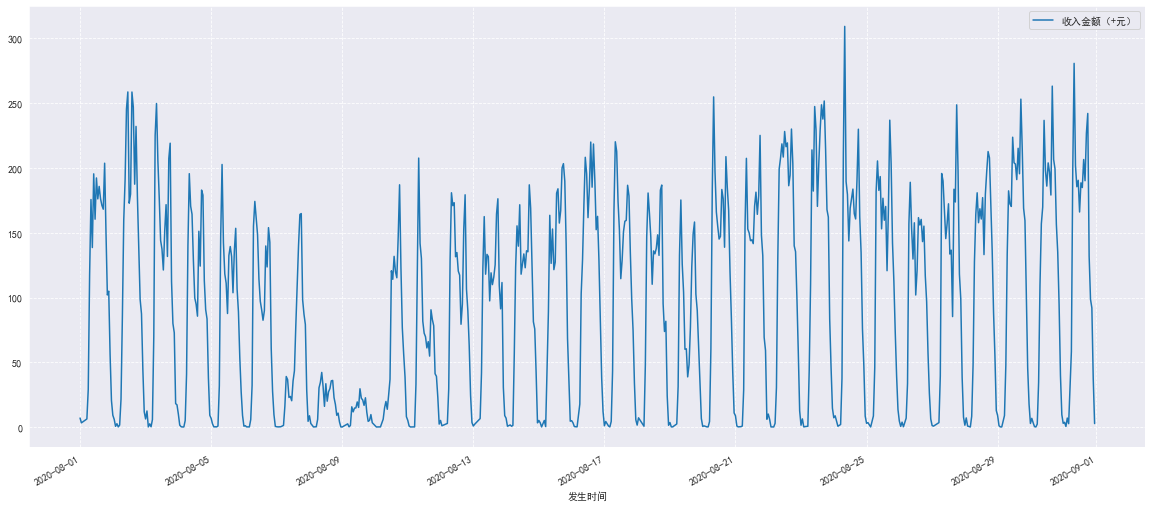

In [32]:
#先看看序列长什么样
df['2020-08'].plot(figsize=(20,9))

In [21]:
# 把收入金额赋给ts方便后续直接调用
ts = df['收入金额（+元）']

In [23]:
#时间序列需要用到的包
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller

### 平稳性检测

##### 自协方差和相关系数函数：ACF、PACF

<ul>自协方差：
    <li>把时间序列的每个点都当作随机变量，并写作$X_t$, 那么两个不同时间变量t,s之间的协方差为：$cov(X_t,X_s) = E[(X_t - \mu_t)(X_s -\mu_s)]$,我们将这个定义为时间序列$\{X_t, t \in T \}$的协方差函数$\gamma(t,s)$。

<ul> 自相关系数函数(Auto-correlation Function, ACF)
    <li>自相关函数即为两个随机变量之间的相关系数，$ \rho(X_t, X_s) = \frac{cov(X_t,X_s}{\sigma_t \sigma_s}$
      <li> 理解：自协方差和自相关系数衡量的是两个不同时刻之间变量的相关程度，可以直观的理解为过去时间对现在时间产生的影响。

<ul> 偏相关系数(Partial Auto-correlation Function, PACF)
    <LI> 推导过程： https://www.jianshu.com/p/811f9ea0b52d
    <li> 理解：由于自相关系数包括了剔除中间间隔所有时间点的影响，所以无法直接描述两个时间点之间的影响。偏相关系数消除了两个时间点之间所有时间点影响，所以可以用于直接描述两个时间点间的相关度。

##### 平稳序列

<ul>平稳序列：
    <li> 平稳序列：常数均值，常数方差，有同样时间间隔的自相关系数和协方差函数值相等。
    <li>理解：时间序列两个变量之间的影响和具体时刻无关，而只和时间间隔有关。
    <li> 强平稳序列(strong stationarity)：$F_X(x_{t_1},x_{t_2},x_{t_3},...,x_{t_m})$ 为时间序列 $\{X_t, t \in T \}$ 在不同时间的变量的联合分布，$\tau$ 为时间跨度。强平稳性要求$$F_X(x_{t_1},x_{t_2},x_{t_3},...,x_{t_m}) =F_X(x_{t_1+\tau},x_{t_2+\tau},x_{t_3+\tau},...,x_{t_m+\tau})$$ 也就是联合分布不受时间参数的影响。    

 <ul> 弱平稳性（广义）平稳性（weak stationarity/wide-sense stationary):
        <li> $E[X(t)] = m_x(t) = m_x(t+\tau)$,均值是常数
            <li> $\sigma_{X_t} = s_x(t) = s_x(t+\tau)$, 方差是常数
            <li>$\gamma(X_t,X_{t+\tau}) = \gamma(X_0,X_{\tau})$ 协方差函数之和时间差有关
    <li> 由于联合分布难以检测，我们一般检测的是弱平稳性。但弱平稳和强平稳之间并没有互相包含的关系，即强平稳不一定弱平稳，反之亦然。

<ul>平稳性检测
    <li> 观察法
<li> 单位根检验法

##### 单位根检验（ADF，Augmented Dickey-Fuller检验）原理

<ul> 单位根概念：
    <li> 以简单的自回归时间序列为例，$ y_t = b y_{t-1} + \epsilon_t $, 若 b = 1, 则存在单位根。
    <li> 存在单位根时，$y_t = y_{t-1} + \epsilon_t $, $ y_t = \sum^{\infty}_{i=0} \epsilon_{t-i}$, 是一个完全由白噪音组成的时间序列，所以肯定不稳定。

<ul> DF检验用于测试一个自回归模型是否存在单位根。
<li> DF检验：回归模型的一阶差分$\delta y_t = (\rho -1) y_{t-1} +u_t = \zeta y_{t-1} + u_t$, DF是关于$\zeta $是否等于0的假设检验
 <li> $H_0： \zeta = 0$, $H_1:  \zeta \neq 0$, 没有单位根
  <li> 使用的假设检验统计量：Dickey-Fuller statistic

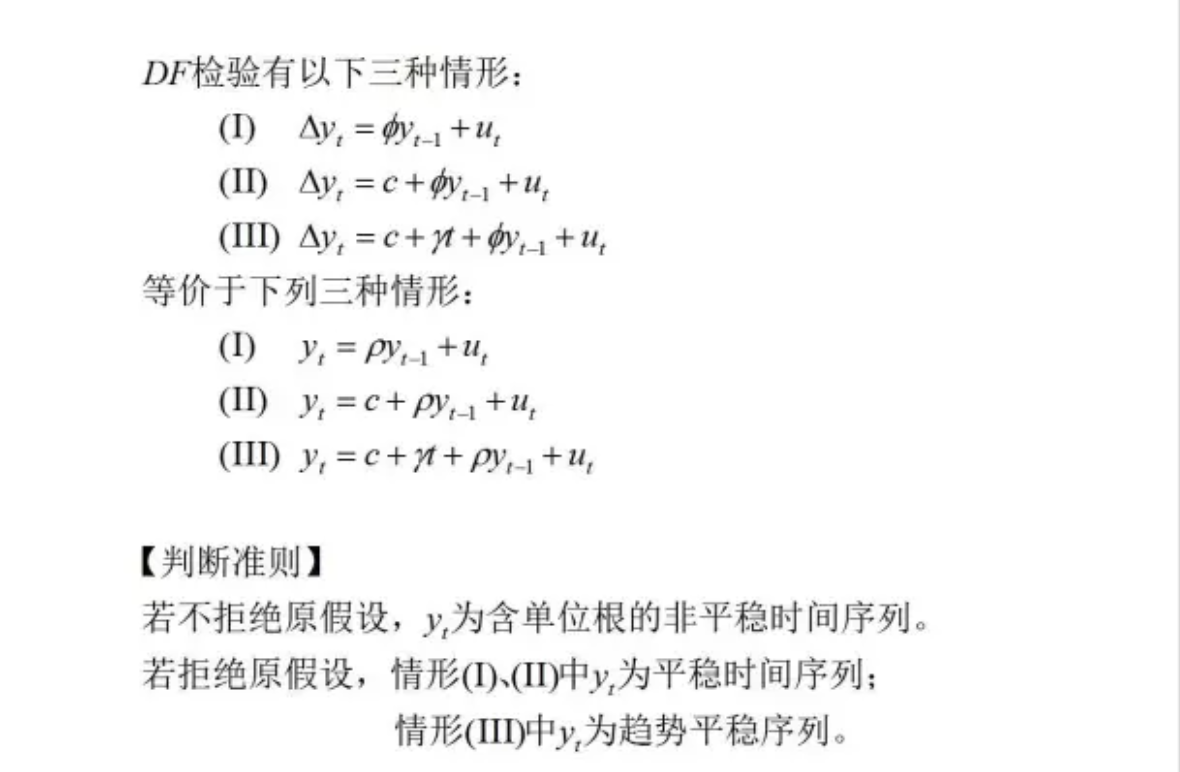

<ul>ADF检验是DF检验的高阶衍生，ADF检验的好处在于它排除了自相关的影响

ADF:

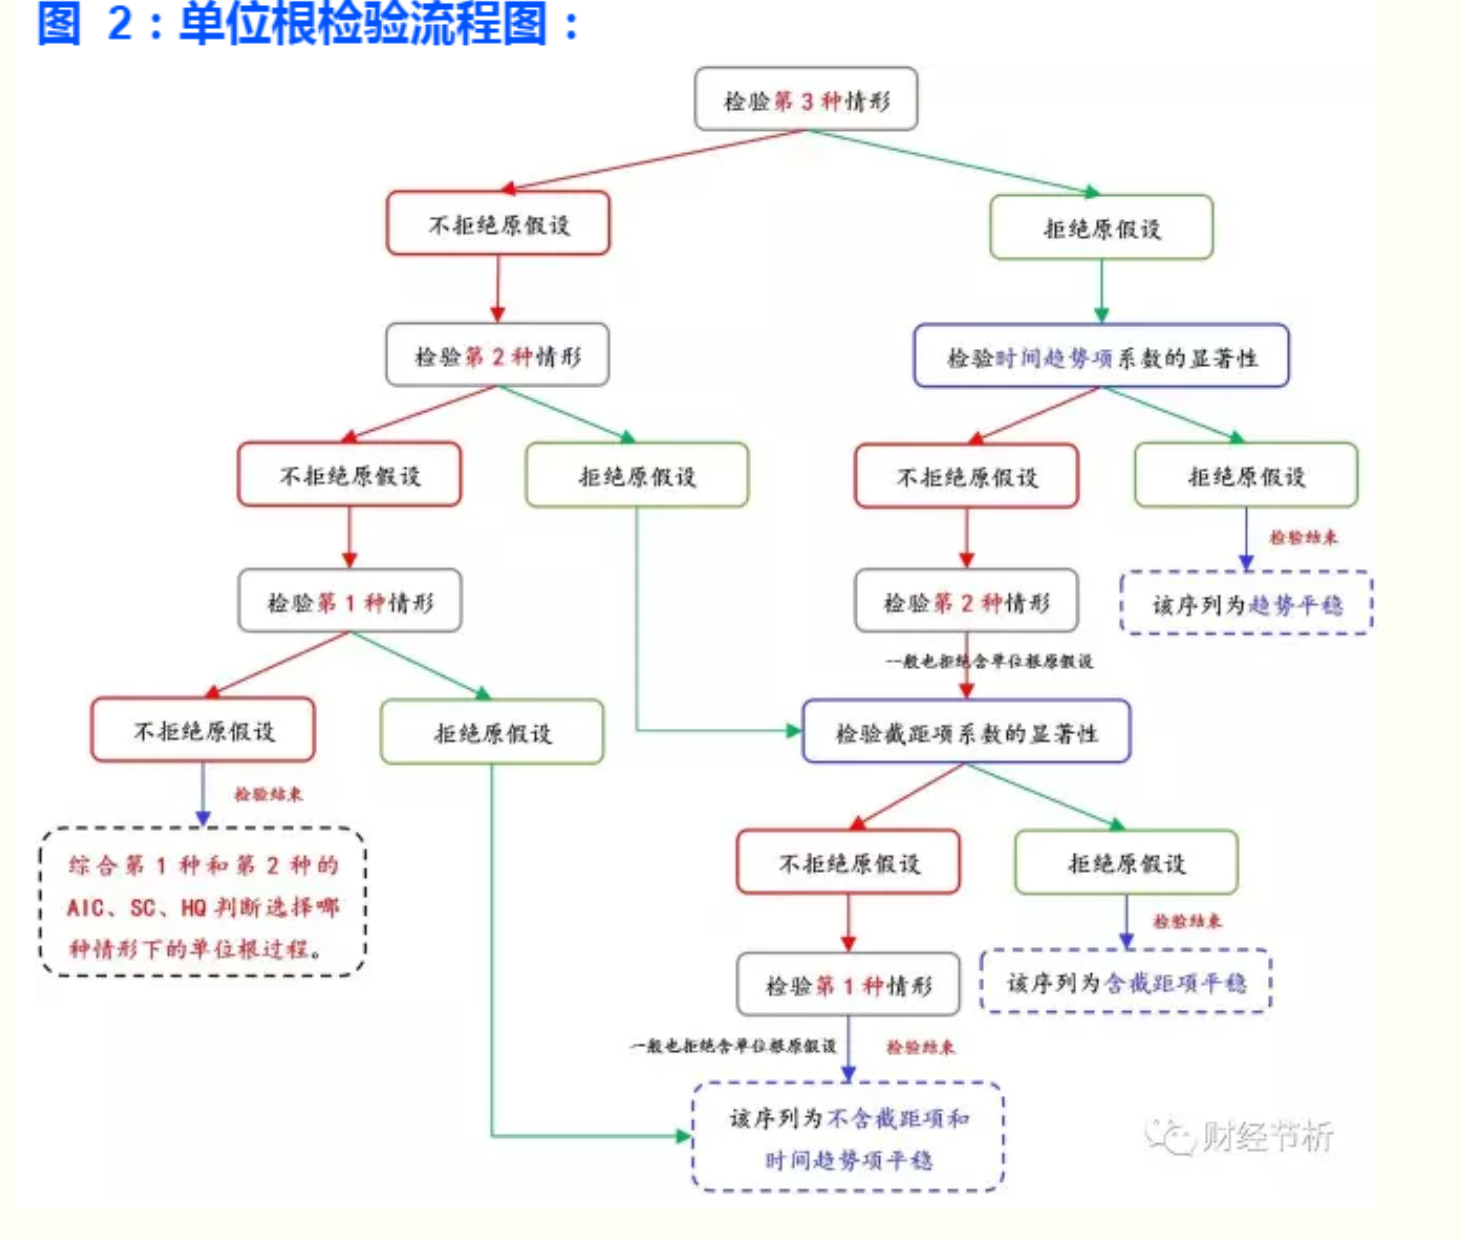

##### Statsmodel 的adfuller()

<ul> ADF的假设检验画图
<li> 

<ul> 参数解释
<li>详见documentation: https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html
<li> statsmodels.tsa.stattools.adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

<ul> 结果解释
 <li> test-statistic，实际统计量
 <li> test_statistic 对应的 p-value
 <li> 不同p值对应的hypothetical test-statistic
  <li> 如果实际统计量小于所选p值对应的理论统计量，或实际统计量对应的p-value小于所选p值，则有（1-p）的自信拒绝该假设

In [42]:
adfuller(ts, maxlag=None, regression='c', autolag='BIC', store=False, regresults=True)

(-3.4233857374678713,
 0.010187022712707309,
 {'1%': -3.4326345265846516,
  '5%': -2.862549348242229,
  '10%': -2.5673073055685},
 <statsmodels.tsa.stattools.ResultsStore at 0x1b0d1a0c588>)

<li> $0.01< p < 0.05$, 结果较为显著，5%的置信区间可以拒绝原假设。

## 模型选择

### 观察pacf和acf图像

#### ACF


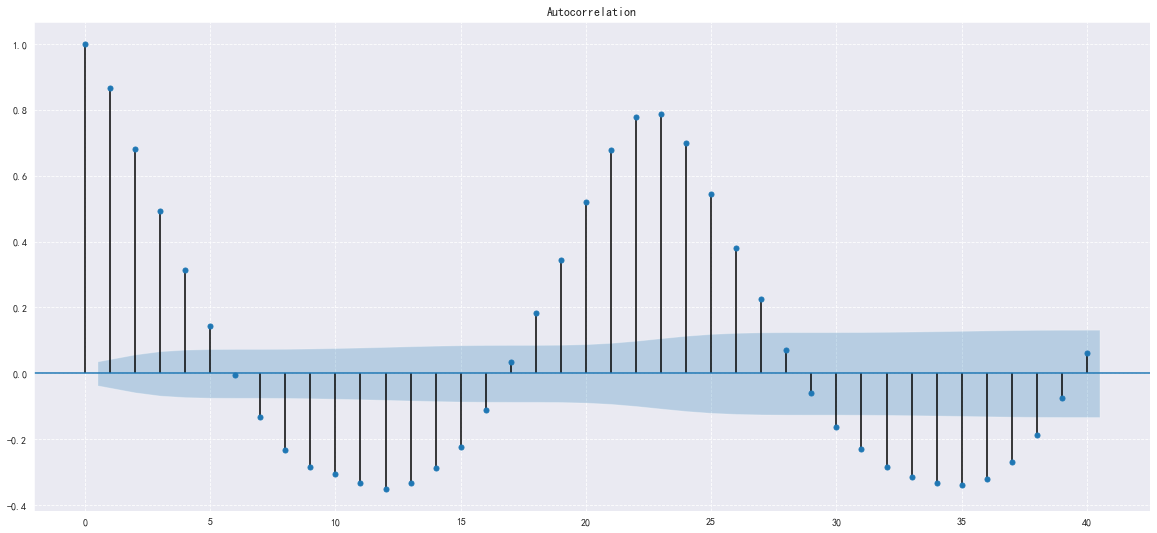

In [44]:
fig, ax = plt.subplots(figsize=(20, 9))
sm.graphics.tsa.plot_acf(ts,lags=40,ax = ax)
plt.rcParams['axes.unicode_minus']=False 
plt.show()

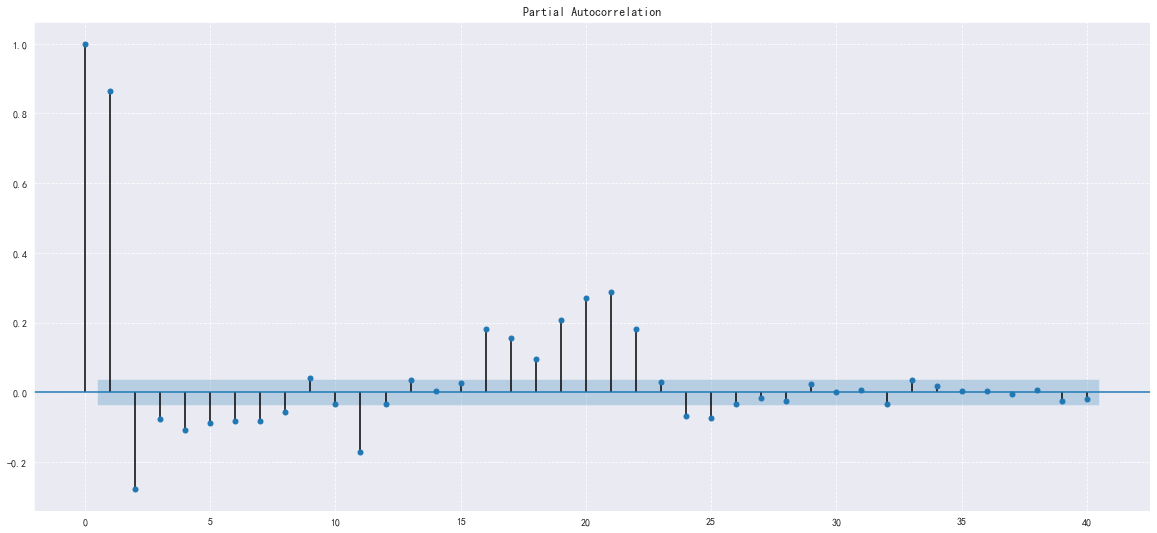

In [45]:
fig, ax = plt.subplots(figsize=(20, 9))
sm.graphics.tsa.plot_pacf(ts,lags=40,ax = ax)
plt.rcParams['axes.unicode_minus']=False 
plt.show()

根据pacf和acf判断，应为两个拖尾，可选用ARMA模型

### 调用R中的Auto forecast

In [ ]:
data= ts2

In [ ]:
robjects.r('library(forecast)')

In [ ]:
robjects.r('library(forecast)')
#下面的四行其实是将Python的list构造成R语言中需要的计算格式，R语言的输入是需要ts对象。
#R中的数组和Python的list不同，需要转化一下
#forecast(nnetar(ts(c(data1,data2,data3,...),frequency=T))）
str_list = ','.join([str(i) for i in data])                
str_array = 'ts(c(' + str_list + '),frequency=%d)'%T
str_model = 'nnetar(%s)' % str_array
str_forcast = 'forecast(%s,h=%d)' % (str_model, h)
#调用上述的字符串，在R中计算
res = robjects.r(str_forcast)
#需要对R计算完成之后的返回的结果进行解析一下，见[说明1]
pred = list(res[-1])